In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import time
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.eyetracker import dlc_utils as dlcutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [2]:
%matplotlib notebook

# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

In [3]:
analysis_type='split_pupil'

responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
trial_epoch='plushalf'

experiment='blobs'
C_value=None
n_iterations=100
overlap_thr=None #0.5
n_processes=1

options=['-E', experiment, '-R', responsive_test, '-r', responsive_thr, '-n', n_processes, '-N', n_iterations, 
         '-o', overlap_thr, '-C', C_value, '-X', analysis_type, '--epoch=%s' % trial_epoch]

In [4]:
#### Extract options
opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = opts.rootdir
create_new = opts.create_new
verbose=opts.verbose

# Pick dataset ------------------------------------ 
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
if responsive_test=='None':
    responsive_test=None
responsive_thr = float(opts.responsive_thr) if responsive_test is not None else 0.05 #10

In [15]:
# Load aggregated data

In [82]:
response_type = 'dff'


#responsive_test='ROC'
#responsive_thr=10. if responsive_test=='nstds' else 0.05
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
stack_neuraldf = analysis_type in ['by_ncells']

#### Check for equal trial counts
visual_areas=['V1', 'Lm', 'Li'] #, 'Ll']
sdata, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=False,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch, #use_all=False,
                        visual_area=curr_visual_area,
                        datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=analysis_type=='by_ncells')

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()


............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


,cell,fov,animalid,session,datakey,fovnum,global_ix
visual_area,,,,,,,
Li,652,652,652,652,652,652,652
Lm,1131,1131,1131,1131,1131,1131,1131
V1,1251,1251,1251,1251,1251,1251,1251


In [83]:
remove_too_few=False
min_ncells=5
has_retino=False
threshold_snr=False
threshold_dff=False
match_distns = False
stack_neuraldf=True

NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                            stack_neuraldf=stack_neuraldf, overlap_thr=overlap_thr, 
                            has_retino=has_retino, threshold_snr=threshold_snr, 
                            remove_too_few=remove_too_few, min_ncells=min_ncells)                               
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())
print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)


~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1131, u'Li': 652}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1131, u'Li': 652}


# Get unique datakeys

In [84]:
drop_repeats = True
drop_repeats_by = 'most_cells' # 'min_missing'

pass_thr=0.10
min_frac=0.5
min_ncells = 5
filter_str = 'aboveshuffle%.2f_missing%.2f_mincells%i' % (pass_thr, min_frac, min_ncells)

drop_str = '_%s' % drop_repeats_by if drop_repeats else ''
dset_str = '_%s_drop_repeats' % filter_str if drop_repeats else '_%s_alldsets' % filter_str

In [85]:
final_dset_fn = 'datasets_%s%s.pkl' % (dset_str, drop_str)
final_dset_fn

'datasets__aboveshuffle0.10_missing0.50_mincells5_drop_repeats_most_cells.pkl'

In [86]:
fns = glob.glob(os.path.join(aggregate_dir, 'decoding', 'split_pupil', responsive_test, final_dset_fn))
print(fns)

fn = fns[0]
dset_filter = os.path.splitext(os.path.split(fn)[-1])[0].split('__')[-1]

print(dset_filter)
with open(fn, 'rb') as f:
    pupil_dsets = pkl.load(f)

print(pupil_dsets[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())
print(pupil_dsets['arousal'].unique())

pupil_dsets = putils.split_datakey(pupil_dsets)

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/ROC/datasets__aboveshuffle0.10_missing0.50_mincells5_drop_repeats_most_cells.pkl']
aboveshuffle0.10_missing0.50_mincells5_drop_repeats_most_cells
V1    8
Lm    7
Li    6
Name: visual_area, dtype: int64
['high' 'high_shuffle' 'low' 'low_shuffle']


In [87]:
pupil_dsets.head()

,visual_area,datakey,condition,arousal,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,...,n_samples_106,iteration,fraction_missing_train,fraction_missing_total,n_missing_train,n_pass_train,feature_sample_ratio,animalid,fov,session
11,Li,20190316_JC070_fov1,data,high,2.51821,0.000863,0.047753,0.023538,0.068893,0.590588,...,42.0,49.5,0.0,0.0,0,300,0.023333,JC070,FOV1_zoom2p0x,20190316
12,Li,20190316_JC070_fov1,data,high_shuffle,2.25469,0.000821,0.011505,-0.002709,0.016598,0.448235,...,42.0,49.5,0.0,0.0,0,300,0.023333,JC070,FOV1_zoom2p0x,20190316
13,Li,20190316_JC070_fov1,data,low,6.75748,0.001843,0.012280,-0.012588,0.017717,0.470000,...,42.0,49.5,0.0,0.0,0,300,0.023333,JC070,FOV1_zoom2p0x,20190316
14,Li,20190316_JC070_fov1,data,low_shuffle,3.73177,0.001204,0.008703,-0.007740,0.012556,0.461176,...,42.0,49.5,0.0,0.0,0,300,0.023333,JC070,FOV1_zoom2p0x,20190316
16,Li,20190316_JC070_fov1,shuffled,high,3.57040,0.001252,0.020415,0.002889,0.029453,0.478824,...,42.0,49.5,0.0,0.0,0,300,0.023333,JC070,FOV1_zoom2p0x,20190316


In [88]:
# Create data ID for labeling figures with data-types
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
filter_str = 'filter_%s' % (dset_filter)

data_id = '%s|%s\n%s' %(traceid, response_str, filter_str)
print(data_id)

traces001|dff_ROC-thr-0.05
filter_aboveshuffle0.10_missing0.50_mincells5_drop_repeats_most_cells


In [132]:
no_inputfile=[]
p_=[]; 
n_=dict((v, dict()) for v in visual_areas)
n_shuffled=dict((v, dict()) for v in visual_areas)

for (visual_area, animalid, session, fov, datakey), g  \
        in pupil_dsets.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):

    curr_id = dc.create_results_id(prefix='split_pupil', C_value=C_value, 
                    visual_area=visual_area, response_type=response_type, responsive_test=responsive_test, 
                    overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
    curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, fov, #'FOV%i_zoom2p0x' % fovnum,
                        'combined_blobs_static', 'traces', '%s*' % traceid, 
                        'decoding', 'inputdata_%s.pkl' % curr_id))
    if len(curr_inputfiles)==0:
        print((visual_area, datakey))
        no_inputfile.append((visual_area, datakey, curr_id))
        continue
        
    assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)

    with open(curr_inputfiles[0], 'rb') as f:
        res = pkl.load(f)  
        
    curr_pupildf = res['pupildf'].copy()
    curr_neuraldf = res['neuraldf'].copy()
    curr_neuraldf_shuffled = res['neuraldf'].copy()
    curr_pupildf['arousal'] = 'all'
    curr_neuraldf['arousal'] = 'all'
    curr_neuraldf_shuffled['arousal'] = 'all'
    
    for a_type in ['high', 'low']:  #, 'high_shuffle', 'low_shuffle']:
        curr_trials = res['%s_ixs' % a_type].astype(int)
        curr_pupildf['arousal'].loc[curr_pupildf['trial'].isin(curr_trials)] = a_type
        curr_neuraldf['arousal'].loc[curr_neuraldf['trial'].isin(curr_trials)] = a_type

        # add shuffled
        curr_t = res['%s_ixs_shuffled' % a_type].astype(int)
        curr_neuraldf_shuffled['arousal'].loc[curr_t] = '%s_shuffled' % a_type
    
    metainfo = {'visual_area': visual_area, 'datakey': datakey}
    curr_neuraldf = aggr.add_meta_to_df(curr_neuraldf, metainfo)
    curr_pupildf = aggr.add_meta_to_df(curr_pupildf, metainfo)
    curr_neuraldf_shuffled = aggr.add_meta_to_df(curr_neuraldf_shuffled, metainfo)
    
    p_.append(curr_pupildf)
    n_[visual_area][datakey] = curr_neuraldf #(curr_neuraldf)
    n_shuffled[visual_area][datakey] = curr_neuraldf_shuffled
    
print("%i have NO INPUT FILES:" % len(no_inputfile))
for i in no_inputfile:
    print i

0 have NO INPUT FILES:


In [133]:
# Aggregate list
neural_input = aggr.neuraldf_dict_to_dataframe(n_)
neural_input_shuffled = aggr.neuraldf_dict_to_dataframe(n_shuffled)

pupil_input = pd.concat(p_, axis=0).reset_index(drop=True)

print(neural_input.head())
print(neural_input_shuffled.head())

  visual_area              datakey     config  trial arousal cell  response
0          V1  20190613_JC097_fov1  config037    1.0    high    1 -0.365451
1          V1  20190613_JC097_fov1  config003    2.0    high    1  0.092418
2          V1  20190613_JC097_fov1  config013    3.0     all    1 -0.328520
3          V1  20190613_JC097_fov1  config029    4.0    high    1  0.087909
4          V1  20190613_JC097_fov1  config021    5.0     all    1 -0.495037
  visual_area              datakey     config  trial        arousal cell  \
0          V1  20190613_JC097_fov1  config037    1.0  high_shuffled    1   
1          V1  20190613_JC097_fov1  config003    2.0   low_shuffled    1   
2          V1  20190613_JC097_fov1  config013    3.0            all    1   
3          V1  20190613_JC097_fov1  config029    4.0   low_shuffled    1   
4          V1  20190613_JC097_fov1  config021    5.0            all    1   

   response  
0 -0.365451  
1  0.092418  
2 -0.328520  
3  0.087909  
4 -0.495037  


In [111]:
datakey = '20190522_JC084_fov1'
session, animalid, fovnum = putils.split_datakey_str(datakey)
curr_id = dc.create_results_id(prefix='split_pupil', C_value=C_value, 
                visual_area=visual_area, response_type=response_type, responsive_test=responsive_test, 
                overlap_thr=overlap_thr, trial_epoch=trial_epoch)

curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                    'combined_blobs_static', 'traces', '%s*' % traceid, 
                    'decoding', 'inputdata_%s.pkl' % curr_id))
curr_inputfiles

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/decoding/inputdata_split_pupil_V1__dff-ROC_noRF__plushalf__tuneC.pkl']

In [112]:

with open(curr_inputfiles[0], 'rb') as f:
    res = pkl.load(f)  
res.keys()

['n_cuts',
 'high_ixs_shuffled',
 'low_ixs',
 'pupildf',
 'matched_labels',
 'sdf',
 'high_ixs',
 'feature_name',
 'equalize_conditions',
 'neuraldf',
 'low_ixs_shuffled']

In [129]:
curr_pupildf = res['pupildf'].copy()
curr_neuraldf = res['neuraldf'].copy()
curr_neuraldf_shuffled = res['neuraldf'].copy()
curr_pupildf['arousal'] = 'all'
curr_neuraldf['arousal'] = 'all'
curr_neuraldf_shuffled['arousal'] = 'all'

for a_type in ['high', 'low']:  #, 'high_shuffle', 'low_shuffle']:
    print(a_type)
    
    curr_trials = res['%s_ixs' % a_type].astype(int)
    curr_pupildf['arousal'].loc[curr_pupildf['trial'].isin(curr_trials)] = a_type
    curr_neuraldf['arousal'].loc[curr_neuraldf['trial'].isin(curr_trials)] = a_type

    # add shuffled
    curr_t = res['%s_ixs_shuffled' % a_type].astype(int)
    curr_neuraldf_shuffled['arousal'].loc[curr_t] = '%s_shuffled' % a_type
    

high
low


In [117]:
[i for i in res['low_ixs_shuffled'].astype(int) if i in res['high_ixs_shuffled'].astype(int)]

[]

In [134]:
neural_input_shuffled.shape, neural_input.shape

((2190912, 7), (2190912, 7))

#### Get original response values (dff)

In [135]:
curr_dst_dir = os.path.join(aggregate_dir, 'correlations', 'arousal', '%s_%s_%s' % (experiment, response_type, responsive_test))
print(curr_dst_dir)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/arousal/blobs_dff_ROC


In [136]:
a_=[]
s_=[]
for (visual_area, datakey), g in neural_input.groupby(['visual_area', 'datakey']):
    # unstack and zscore
#     x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
#     x1 = aggr.stacked_neuraldf_to_unstacked(x0)
#     x2 = aggr.zscore_neuraldf(x1)
#     # restack
#     ndf = aggr.unstacked_neuraldf_to_stacked(x2, id_vars=id_vars)
    ndf = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
    
    # Assign arousal conds
    tmpdf = ndf.copy() #.loc[all_trials]
    tmpdf['arousal']='all'
    for acond in ['high', 'low']:
        curr_trials = g[g.arousal==acond]['trial'].values
        tmpdf['arousal'].loc[tmpdf['trial'].isin(curr_trials)] = acond
    tmpdf['visual_area'] = visual_area
    tmpdf['datakey'] = datakey
    a_.append(tmpdf)
    
    # Shuffled
    g_shuff = neural_input_shuffled[(neural_input_shuffled.visual_area==visual_area)
                                   & (neural_input_shuffled.datakey==datakey)].copy()
    shuffdf = ndf.copy()
    shuffdf['arousal']='all'
    for acond in ['high_shuffled', 'low_shuffled']:
        curr_trials = g_shuff[g_shuff.arousal==acond]['trial'].values
        shuffdf['arousal'].loc[shuffdf['trial'].isin(curr_trials)] = acond
    shuffdf['visual_area'] = visual_area
    shuffdf['datakey'] = datakey
    s_.append(shuffdf)
    
responsedf = pd.concat(a_, axis=0).reset_index(drop=True)
responsedf_shuffled = pd.concat(s_, axis=0).reset_index(drop=True)

In [137]:
visual_area='V1'
datakey = '20190507_JC083_fov1'
ndf = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()

In [138]:
responsedf.shape, responsedf_shuffled.shape

((2389656, 7), (2389656, 7))

In [139]:
#### Get averages by cell/by fov
use_original_data=True

if use_original_data:
    inputdf = responsedf.copy()
    shuffledf = responsedf_shuffled.copy()
else:
    inputdf = neural_input.copy()
    shuffledf = neural_input_shuffled.copy()
    
ylabel = 'dff' if use_original_data else 'z-dff'

means_by_cell = inputdf.groupby(['visual_area', 'datakey', 'cell', 'arousal' ]).mean()\
                        .reset_index() #.drop('cell', axis=1)
means_by_cell_shuffled = shuffledf.groupby(['visual_area', 'datakey', 'cell', 'arousal' ])\
                        .mean().reset_index() #.drop('cell', axis=1)

means_by_fov = means_by_cell.groupby(['visual_area', 'datakey', 'arousal' ]).mean().reset_index()
means_by_fov_shuffled = means_by_cell_shuffled.groupby(['visual_area', 'datakey', 'arousal' ]).mean().reset_index()

In [140]:
means_by_fov_shuffled.head()

,visual_area,datakey,arousal,cell,trial,response
0,Li,20190316_JC070_fov1,all,125.714286,662.266667,0.009961
1,Li,20190316_JC070_fov1,high_shuffled,125.714286,557.454545,0.008050
2,Li,20190316_JC070_fov1,low_shuffled,125.714286,714.513736,0.010459
3,Li,20190322_JC073_fov1,all,219.473684,674.644841,0.020689
4,Li,20190322_JC073_fov1,high_shuffled,219.473684,494.400000,0.030310


<IPython.core.display.Javascript object>


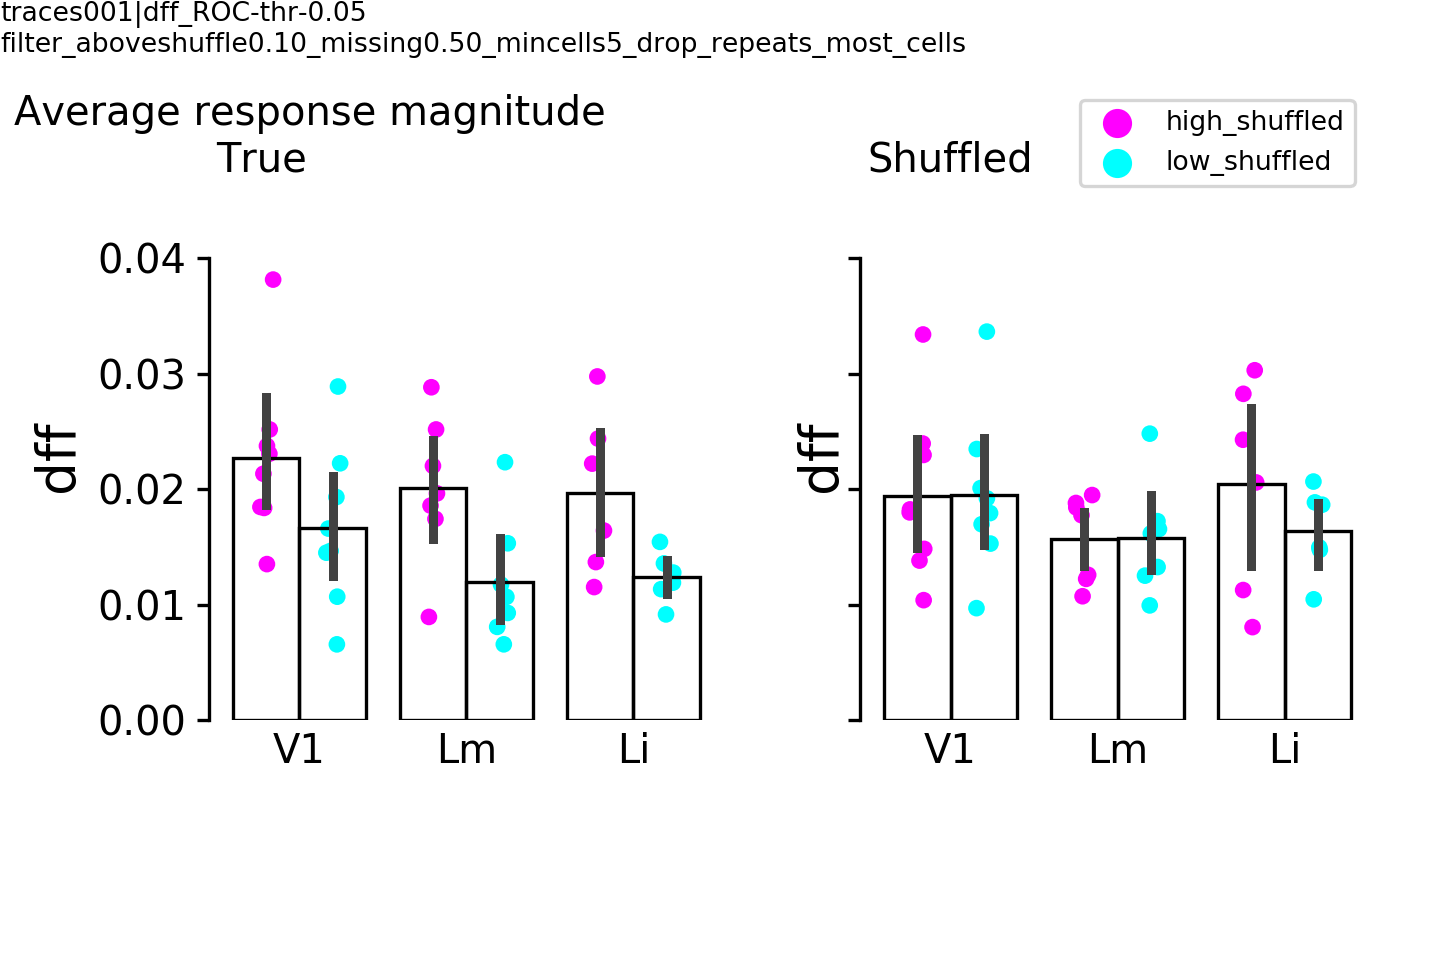

('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/arousal/blobs_dff_ROC', 'mean_dff_by_fov')


In [141]:
palette=['magenta', 'cyan']
plot_cells=False

plotdf = means_by_cell.copy().drop('cell', axis=1) if plot_cells else means_by_fov.copy().drop('cell', axis=1)
plotdf_shuffled = means_by_cell_shuffled.copy() if plot_cells else means_by_fov_shuffled.copy()

markersize=2 if plot_cells else 5
plot_str='all_cells' if plot_cells else 'by_fov'


fig, axn = pl.subplots(1, 2, figsize=(6,4), dpi=dpi, sharex=True, sharey=True) #, dpi=dpi)

ax=axn[0]
c1='high'; c2='low';
df_ = plotdf[plotdf.arousal!='all']
sns.stripplot(x='visual_area', y='response', hue='arousal', data=df_, ax=ax, 
              palette=palette, dodge=True, zorder=-1, order=visual_areas, size=markersize)
sns.barplot(x='visual_area', y='response', hue='arousal', data=df_, ax=ax,
            edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas, zorder=-1)
df_.apply(aggr.annotateBars, ax=ax,fontsize=8, fontcolor='k', xytext=(0, -130))
ax.set_title('True', loc='left')
ax.legend_.remove()

ax=axn[1]
c1='high_shuffled'; c2='low_shuffled';
df_ = plotdf_shuffled[plotdf_shuffled.arousal!='all']
sns.stripplot(x='visual_area', y='response', hue='arousal', data=df_, ax=ax, 
              palette=palette, dodge=True, zorder=-1, order=visual_areas, size=markersize)
sns.barplot(x='visual_area', y='response', hue='arousal', data=df_, ax=ax,
            edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas, zorder=-1)
df_.apply(aggr.annotateBars, ax=ax,fontsize=8, fontcolor='k', xytext=(0, -130))
ax.set_title('Shuffled', loc='left')

sns.despine(trim=True, offset=2, bottom=True)
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
pl.subplots_adjust(left=0.15, bottom=0.25, right=0.95, wspace=0.3, top=0.8)
aggr.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1, 1.2), loc='upper right', fontsize=8)
fig.text(0.01, 0.87, 'Average response magnitude', fontsize=12)

putils.label_figure(fig, '%s' % data_id)

figname = 'mean_%s_%s' % (ylabel, plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## paired

In [142]:
def paired_arousal_plot_and_stats(df_, metric='response', 
                                c1='high', c2='low', compare_var='arousal',
                                ax=ax, area_colors='colorblind', 
                                legend=False, bbox_to_anchor=(0.5, 1),
                                xytext=(0, -80), fontsize=8):
    
    c1_label='H' if 'high' in c1 else 'L'
    c2_label='L' if 'low' in c2 else 'H'
    ax = aggr.plot_pairwise_by_axis(df_, curr_metric=metric, xytext=xytext, fontsize=fontsize,
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=legend, bbox_to_anchor=bbox_to_anchor,
                                c1_label=c1_label, c2_label=c2_label)
    
    ax.set_xlabel('')
    ax.set_title("True labels", loc='left')
    statdf = aggr.paired_ttests(df_, curr_metric=metric, c1=c1, c2=c2, compare_var=compare_var)

    return statdf, ax

<IPython.core.display.Javascript object>


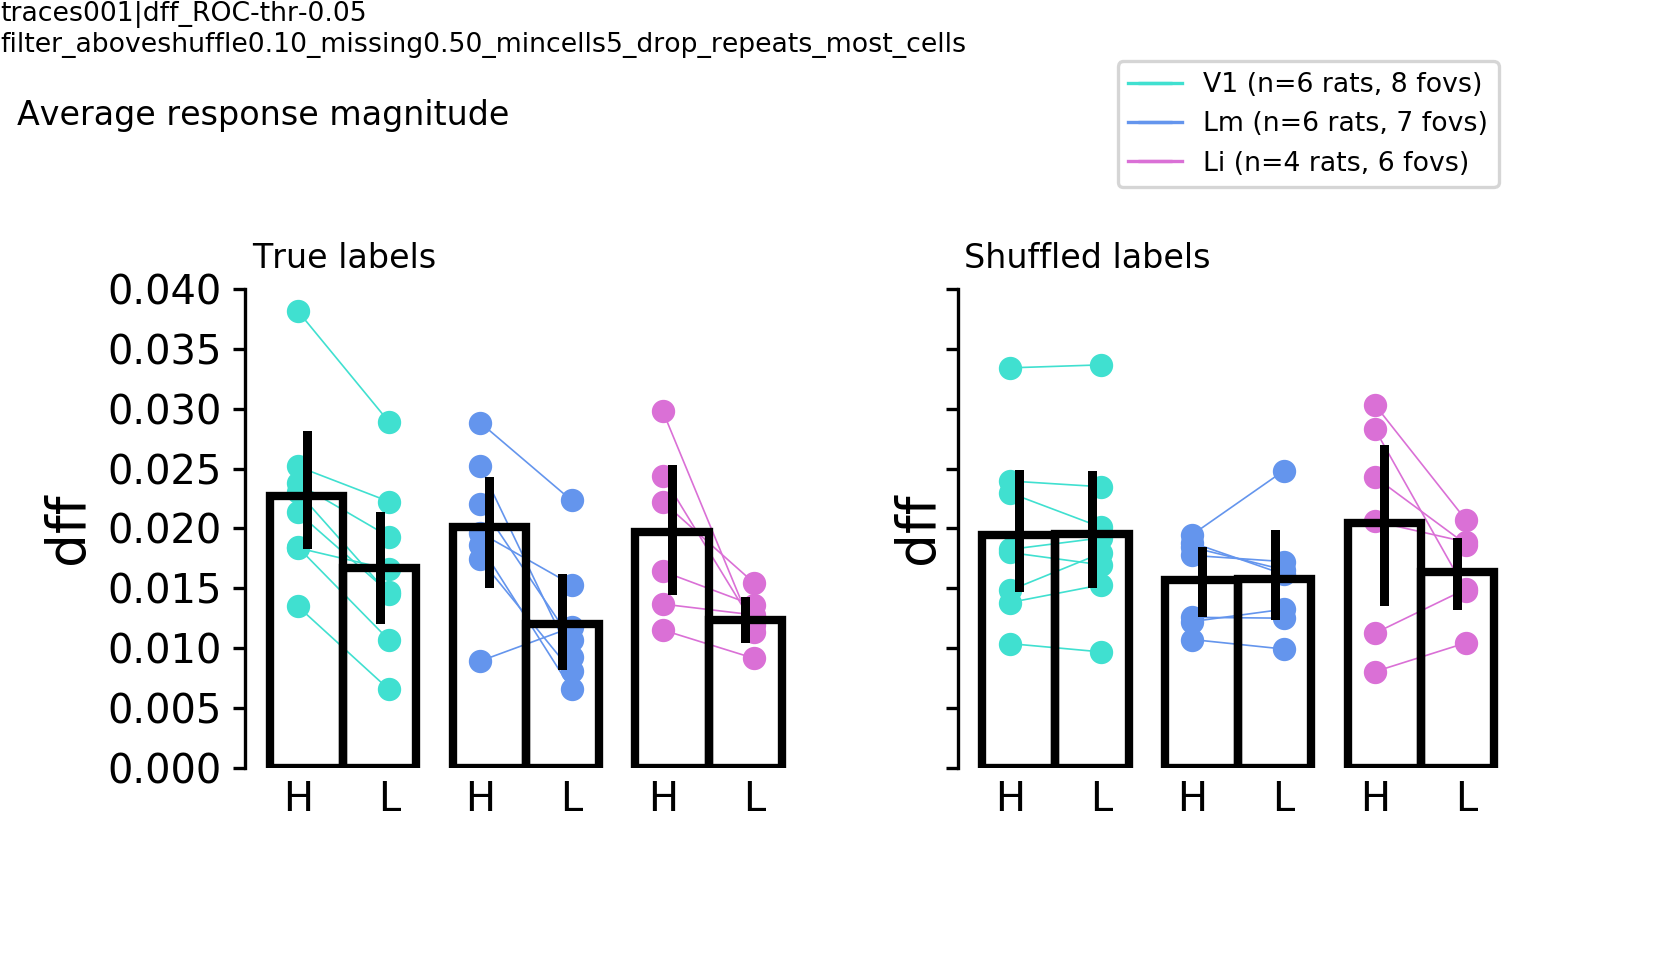

(t-stat:6.32, p=0.00)
(t-stat:3.50, p=0.01)
(t-stat:2.60, p=0.05)
V1: 6.32 (p=0.00)
Lm: 3.50 (p=0.01)
Li: 2.60 (p=0.05)
(t-stat:-0.14, p=0.89)
(t-stat:-0.07, p=0.95)
(t-stat:1.47, p=0.20)
V1: -0.14 (p=0.89)
Lm: -0.07 (p=0.95)
Li: 1.47 (p=0.20)
('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/arousal/blobs_dff_ROC', 'mean_dff_paired_by_fov')


In [143]:
palette=['magenta', 'cyan']
plot_cells=False
metric='response'
compare_var = 'arousal'

plotdf = means_by_cell.copy().drop('cell', axis=1) if plot_cells else means_by_fov.copy().drop('cell', axis=1)
plotdf_shuffled = means_by_cell_shuffled.copy().drop('cell', axis=1) if plot_cells else means_by_fov_shuffled.copy().drop('cell', axis=1)

markersize=2 if plot_cells else 5
plot_str='all_cells' if plot_cells else 'by_fov'


fig, axn = pl.subplots(1, 2, figsize=(7,4), dpi=dpi, sharex=True, sharey=True) #, dpi=dpi)
# true
ax=axn[0]
c1='high'; c2='low';
df_ = plotdf[plotdf.arousal!='all']
statdf0, ax = paired_arousal_plot_and_stats(df_, metric=metric, xytext=(0, -150), fontsize=8,
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=False)
ax.set_title("True labels", loc='left', fontsize=10)
statdf0['condition'] = 'data'


# shuffled
ax=axn[1]
c1='high_shuffled'; c2='low_shuffled';
df_ = plotdf_shuffled[plotdf_shuffled.arousal!='all']
statdf1, ax = paired_arousal_plot_and_stats(df_, metric=metric, xytext=(0, -150), fontsize=6,
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1, 1.5))
ax.set_title("Shuffled labels", loc='left', fontsize=10)
statdf1['condition'] = 'shuffled'

# format
statdf = pd.concat([statdf0, statdf1])

sns.despine(trim=True, offset=2, bottom=True)
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.9, wspace=0.3, top=0.7)
fig.text(0.01, 0.87, 'Average response magnitude', fontsize=10)

putils.label_figure(fig, '%s' % data_id)

figname = 'mean_%s_paired_%s' % (ylabel, plot_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [144]:
print("Mean (true) ~~~~~~~~~~~~~~~~~~~~~~~~")
print(plotdf.groupby(['visual_area', 'arousal']).mean()['response'].reset_index())

print("Mean (shuffled) ~~~~~~~~~~~~~~~~~~~~~~~~")
print(plotdf_shuffled.groupby(['visual_area', 'arousal']).mean()['response'].reset_index())
plotdf = aggr.split_datakey(plotdf)

print("N rats:")
print(plotdf[['visual_area', 'animalid']].drop_duplicates()['visual_area'].value_counts())
print("N sites:")
print(plotdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())


Mean (true) ~~~~~~~~~~~~~~~~~~~~~~~~
  visual_area arousal  response
0          Li     all  0.015834
1          Li    high  0.019667
2          Li     low  0.012363
3          Lm     all  0.015806
4          Lm    high  0.020088
5          Lm     low  0.011996
6          V1     all  0.020043
7          V1    high  0.022734
8          V1     low  0.016682
Mean (shuffled) ~~~~~~~~~~~~~~~~~~~~~~~~
  visual_area        arousal  response
0          Li            all  0.015786
1          Li  high_shuffled  0.020461
2          Li   low_shuffled  0.016391
3          Lm            all  0.015914
4          Lm  high_shuffled  0.015715
5          Lm   low_shuffled  0.015780
6          V1            all  0.020135
7          V1  high_shuffled  0.019452
8          V1   low_shuffled  0.019541
N rats:
V1    6
Lm    6
Li    4
Name: visual_area, dtype: int64
N sites:
V1    8
Lm    7
Li    6
Name: visual_area, dtype: int64


# Correlations

In [145]:
def calculate_signal_corrs(g_mat, included_configs=None):
    if included_configs is None:
        included_configs = g_mat['config'].unique()
        
    tuning_ = g_mat[g_mat['config'].isin(included_configs)].groupby(['config']).mean().reset_index()
    cc = putils.melt_square_matrix(tuning_.corr(), metric_name='signal_cc', include_diagonal=False)
    
    return cc

In [146]:
def calculate_noise_corrs(g_mat, included_configs=None):
    if included_configs is None:
        included_configs = g_mat['config'].unique()
        
    rlist = [r for r in g_mat.columns if putils.isnumber(r)]
    tmeans = pd.concat([pd.concat([cdf[rlist] - cdf[rlist].mean(), cdf['config']], axis=1) \
                            for cfg, cdf in g_mat.groupby(['config'])]).reset_index(drop=True)

    # Calculate noise corr: ncorrs[(ncorrs['row']==0) & (ncorrs['col']==1)] 
    # noise corrs, all conditions for neuron i, j (i=0, j=1)
    ncorrs = pd.concat([putils.melt_square_matrix(resp.corr(), metric_name='noise_cc', 
                                           add_values={'config': cfg}, include_diagonal=False) 
                        for cfg, resp in \
                            tmeans[tmeans['config'].isin(included_configs)].groupby(['config'])], axis=0)
    
    # Get mean noise corr over all stim conds for each pair
    cc = ncorrs.groupby(['row', 'col']).mean().reset_index()
    
    return cc


In [147]:
arousal_conditions = ['all', 'high', 'low', 'high_shuffled', 'low_shuffled']
arousal_colors = {'all': 'k', 'low': 'c', 'high': 'm', 'low_shuffled': 'b', 'high_shuffled': 'r'}

In [148]:
responsedf.head()

,visual_area,datakey,config,trial,cell,response,arousal
0,Li,20190316_JC070_fov1,config010,1,29,0.021302,all
1,Li,20190316_JC070_fov1,config025,2,29,-0.021896,all
2,Li,20190316_JC070_fov1,config037,3,29,0.002304,high
3,Li,20190316_JC070_fov1,config008,4,29,-0.020331,high
4,Li,20190316_JC070_fov1,config011,5,29,-0.005980,all


### Signal correlations

In [149]:
responsedf['arousal'].unique()

array(['all', 'high', 'low'], dtype=object)

In [150]:
#### Get averages by cell/by fov
use_original_data=True

if use_original_data:
    inputdf = responsedf.copy()
    shuffledf = responsedf_shuffled.copy()
else:
    inputdf = neural_input.copy()
    shuffledf = neural_input_shuffled.copy()
    

In [172]:
inputdf['arousal'].unique()

array(['all', 'high', 'low'], dtype=object)

In [154]:
class_a = 0
class_b=106

In [167]:
x_list = []
for (visual_area, datakey, arousal_cond), ndf in inputdf.groupby(['visual_area', 'datakey', 'arousal']):
    sdf = SDF[datakey].copy()
    session, animalid, fovnum = putils.split_datakey_str(datakey)
    
    #included_configs = sdf[sdf.morphlevel!=-1].index.tolist()
    included_configs = sdf[sdf.morphlevel.isin([class_a, class_b])].index.tolist()

    # true
    g_mat = aggr.stacked_neuraldf_to_unstacked(ndf)
    g_mat.columns = g_mat.columns.tolist()
    cc = calculate_signal_corrs(g_mat, included_configs=included_configs)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey, 'arousal': arousal_cond,
             'condition': 'data'}
    cc = aggr.add_meta_to_df(cc, metadict)
    x_list.append(cc)
    
    # shuffled
    if arousal_cond=='all':
        continue
    ndf_shuffled = shuffledf[(shuffledf.visual_area==visual_area) & (shuffledf.datakey==datakey)
                         & (shuffledf.arousal=='%s_shuffled' % arousal_cond)].copy()
    g_mat1 = aggr.stacked_neuraldf_to_unstacked(ndf_shuffled)
    g_mat1.columns = g_mat1.columns.tolist()
    cc1 = calculate_signal_corrs(g_mat1, included_configs=included_configs)
    metadict1 = copy.copy(metadict)
    metadict1.update({'condition': 'shuffled'})
    cc1 = aggr.add_meta_to_df(cc1, metadict1)
    x_list.append(cc1)
    
signal_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

In [168]:
# Get mean across animals
mean_signal_corrs = signal_corrs.groupby(['visual_area', 'datakey', 'arousal', 'condition']).mean().reset_index()
mean_signal_corrs.head()

,visual_area,datakey,arousal,condition,col,fovnum,row,signal_cc
0,Li,20190316_JC070_fov1,all,data,176.571429,1.0,74.857143,0.130156
1,Li,20190316_JC070_fov1,high,data,176.571429,1.0,74.857143,0.194388
2,Li,20190316_JC070_fov1,low,data,176.571429,1.0,74.857143,0.603441
3,Li,20190316_JC070_fov1,low,shuffled,176.571429,1.0,74.857143,0.245691
4,Li,20190322_JC073_fov1,all,data,251.596017,1.0,187.351351,0.212328


<IPython.core.display.Javascript object>


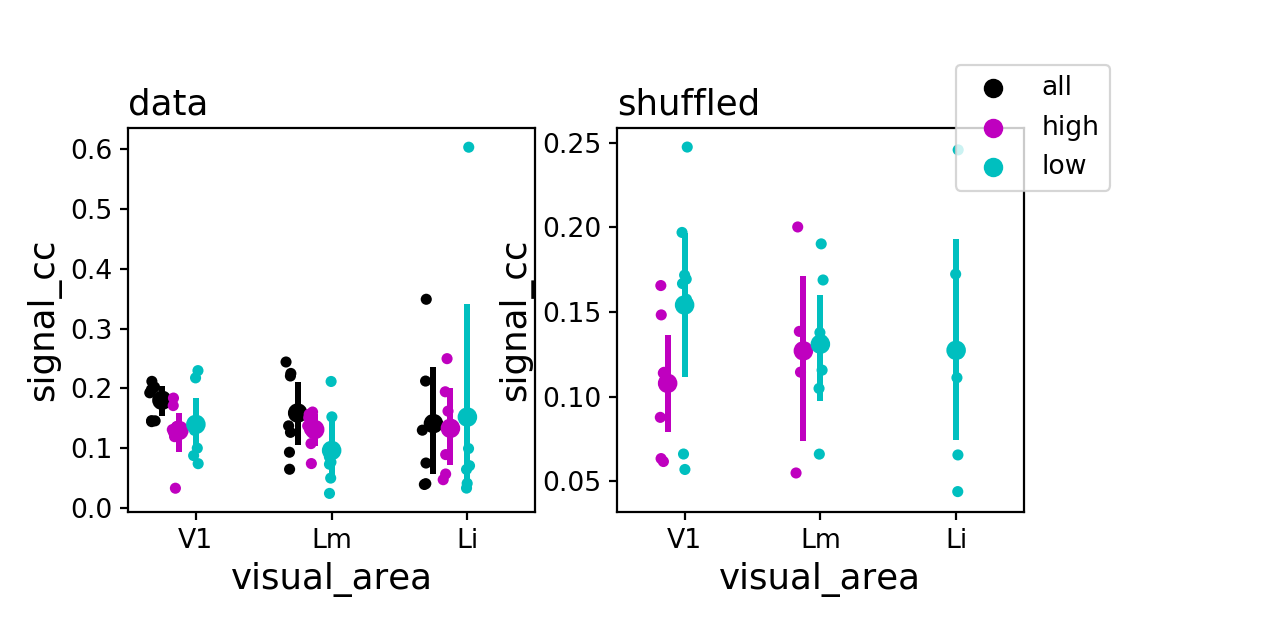

In [173]:
fig, axn = pl.subplots(1,2, figsize=(8,4))

for ax, (cond, g) in zip(axn.flat, mean_signal_corrs.groupby(['condition'])):
    ax.set_title(cond, loc='left', fontsize=16)
    sns.stripplot(x='visual_area', y='signal_cc', data=g, ax=ax,
                 hue='arousal', palette=arousal_colors, hue_order=arousal_conditions,
                  order=visual_areas, dodge=True)
    
    sns.pointplot(x='visual_area', y='signal_cc', data=g, ax=ax,
                 hue='arousal', palette=arousal_colors, hue_order=arousal_conditions,
                  order=visual_areas, dodge=0.5, join=False)
    ax.legend_.remove()
    
aggr.crop_legend_labels(axn[-1], n_hues=3, bbox_to_anchor=(0.8, 1.2), n_cols=1)

pl.subplots_adjust(left=0.1, bottom=0.2, right=0.8, top=0.8)


In [497]:
# visual_area='V1'
# datakey = '20190522_JC084_fov1'
# arousal_cond = 'high'


# ndf = inputdf[(inputdf.visual_area==visual_area) & (inputdf.datakey==datakey)].copy()
# sdf = SDF[datakey].copy()
# included_configs = sdf[sdf.morphlevel!=-1].index.tolist()
# session, animalid, fovnum = putils.split_datakey_str(datakey)

# # true
# fig, axn = pl.subplots(1,3, figsize=(9,3))
# ai=0
# for arousal_cond, g in ndf.groupby(['arousal']):
#     ai = ['all', 'high', 'low'].index(arousal_cond)
#     ax=axn[ai]
#     g_mat = aggr.stacked_neuraldf_to_unstacked(g)
#     cc = calculate_signal_corrs(g_mat, included_configs=train_configs)
#     tuning_ = g_mat[g_mat['config'].isin(train_configs)].groupby(['config']).mean().reset_index()
#     sns.clustermap(tuning_.corr(), cmap='RdBu', vmin=-1, vmax=1)
#     ax.set_title(arousal_cond, loc='left')
#     ax.set_aspect('equal')
    

### Noise correlations

In [181]:
g_mat1[g_mat1.config.isin(included_configs)].shape

(0, 8)

In [186]:
x_list = []
for (visual_area, datakey, arousal_cond), ndf in inputdf.groupby(['visual_area', 'datakey', 'arousal']):
    
    sdf = SDF[datakey].copy()
    
    #included_configs = sdf[sdf.morphlevel!=-1].index.tolist()
    included_configs = sdf[sdf.morphlevel.isin([class_a, class_b])].index.tolist()
    
    session, animalid, fovnum = putils.split_datakey_str(datakey)
    g_mat = aggr.stacked_neuraldf_to_unstacked(ndf)
    if g_mat[g_mat.config.isin(included_configs)].shape[0]==0:
        continue
    # mean-subtract
    cc = calculate_noise_corrs(g_mat, included_configs=included_configs)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey, 'arousal': arousal_cond,
             'condition': 'data'}
    cc = putils.add_meta_to_df(cc, metadict)
    
    # shuffled
    if arousal_cond=='all':
        continue
    ndf_shuffled = shuffledf[(shuffledf.visual_area==visual_area)& (shuffledf.datakey==datakey)
                         & (shuffledf.arousal=='%s_shuffled' % arousal_cond)].copy()
    g_mat1 = aggr.stacked_neuraldf_to_unstacked(ndf_shuffled)
    if g_mat1[g_mat1.config.isin(included_configs)].shape[0]==0:
        continue
    cc1 = calculate_noise_corrs(g_mat1, included_configs=included_configs)
    metadict1 = copy.copy(metadict)
    metadict1.update({'condition': 'shuffled'})
    cc1 = putils.add_meta_to_df(cc1, metadict1)
    
    x_list.append(cc1)
    x_list.append(cc)
noise_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)


In [187]:
# Get mean across animals
mean_noise_corrs = noise_corrs.groupby(['visual_area', 'datakey', 'arousal']).mean().reset_index()

In [188]:
mean_noise_corrs['arousal'].unique()

array(['low', 'high'], dtype=object)

In [189]:
metric = 'signal_cc'
currd = mean_noise_corrs.copy() if metric=='noise_cc' else mean_signal_corrs.copy()

compare_var='arousal'

c1='high'; c2='low';

fig, axn = pl.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True) #, dpi=dpi)
ax=axn[0]
c1='high'; c2='low';
df_ = currd[currd.arousal.isin([c1, c2])]
statdf0, ax = paired_arousal_plot_and_stats(df_[df_.condition=='data'], metric=metric, xytext=(0, -150), fontsize=8,
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=False)
ax.set_title("True labels", loc='left', fontsize=10)
statdf0['condition'] = 'data'

# shuffled
ax=axn[1]
df_ = currd[currd.arousal.isin([c1, c2])]
statdf1, ax = paired_arousal_plot_and_stats(df_[df_.condition=='shuffled'], metric=metric, xytext=(0, -150), fontsize=6,
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1, 1.5))
ax.set_title("Shuffled labels", loc='left', fontsize=10)
statdf1['condition'] = 'shuffled'

statdf = pd.concat([statdf0, statdf1], axis=1)

fig.text(0.02, 0.93, "Correlations", fontsize=12)

# pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, wspace=0.5, top=0.8)
# putils.label_figure(fig, '%s\n%s%s' % (data_id, dset_str, drop_str))

# figname = 'paired_and_shuffled__hi-lo_pass-%.2f__%s__%s%s' % (pass_thr, metric, dset_str, drop_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>

(t-stat:-0.47, p=0.65)
(t-stat:1.59, p=0.16)
(t-stat:-0.23, p=0.83)
V1: -0.47 (p=0.65)
Lm: 1.59 (p=0.16)
Li: -0.23 (p=0.83)


ValueError: unequal length arrays

<IPython.core.display.Javascript object>


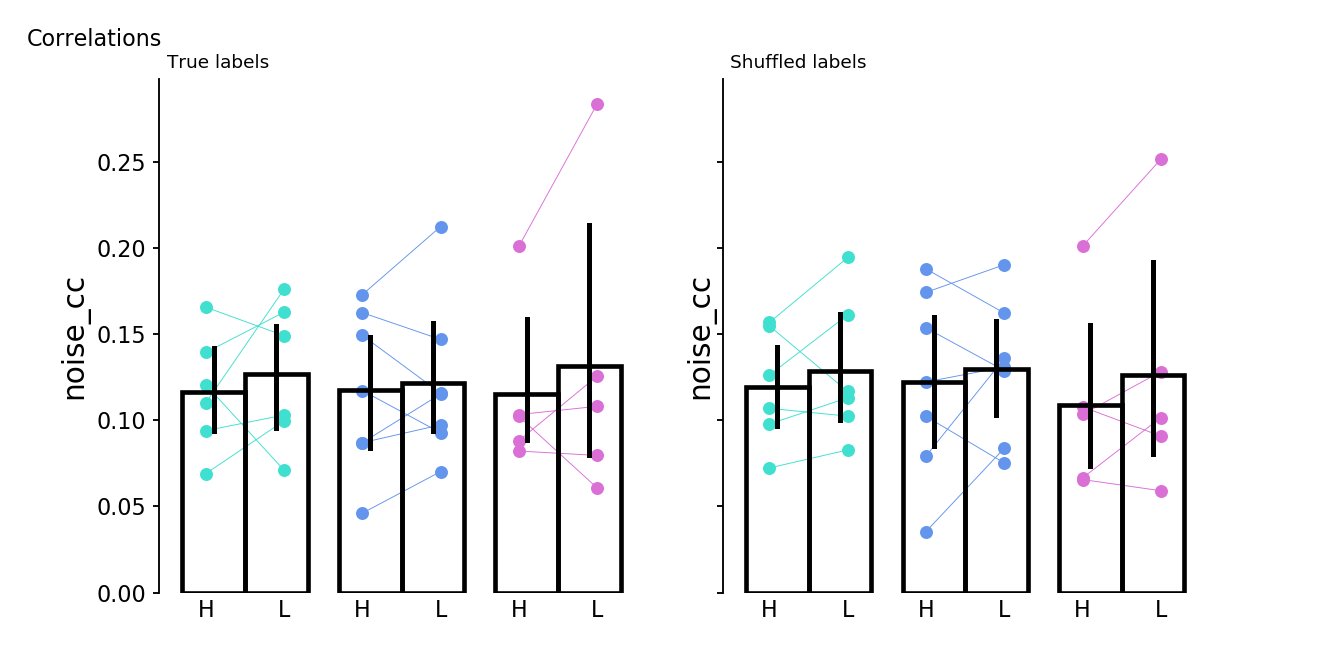

(t-stat:-0.64, p=0.55)
(t-stat:-0.38, p=0.72)
(t-stat:-0.78, p=0.48)
V1: -0.64 (p=0.55)
Lm: -0.38 (p=0.72)
Li: -0.78 (p=0.48)
(t-stat:-0.81, p=0.45)
(t-stat:-0.56, p=0.60)
(t-stat:-1.37, p=0.24)
V1: -0.81 (p=0.45)
Lm: -0.56 (p=0.60)
Li: -1.37 (p=0.24)


Text(0.02,0.93,u'Correlations')

In [444]:
metric = 'noise_cc'
currd = mean_noise_corrs.copy() if metric=='noise_cc' else mean_signal_corrs.copy()

compare_var='arousal'

c1='high'; c2='low';

fig, axn = pl.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True) #, dpi=dpi)
ax=axn[0]
c1='high'; c2='low';
df_ = currd[currd.arousal.isin([c1, c2])]
statdf0, ax = paired_arousal_plot_and_stats(df_, metric=metric, xytext=(0, -150), fontsize=8,
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=False)
ax.set_title("True labels", loc='left', fontsize=10)
statdf0['condition'] = 'data'

# shuffled
ax=axn[1]
c1='high_shuffled'; c2='low_shuffled';
df_ = currd[currd.arousal.isin([c1, c2])]
statdf1, ax = paired_arousal_plot_and_stats(df_, metric=metric, xytext=(0, -150), fontsize=6,
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1, 1.5))
ax.set_title("Shuffled labels", loc='left', fontsize=10)
statdf1['condition'] = 'shuffled'

statdf = pd.concat([statdf0, statdf1], axis=1)

fig.text(0.02, 0.93, "Correlations", fontsize=12)

In [452]:
signal_corrs.iloc[10578]

row                            523
col                             72
signal_cc                0.0149416
animalid                     JC091
session                   20190614
arousal                        all
datakey        20190614_JC091_fov1
visual_area                     Li
fovnum                           1
Name: 10578, dtype: object

In [453]:
noise_corrs.iloc[10578]

row                             72
col                             74
noise_cc                  0.255546
animalid                     JC091
session                   20190614
arousal                        all
datakey        20190614_JC091_fov1
visual_area                     Li
fovnum                           1
Name: 10578, dtype: object

#### Merge correlation dfs

In [468]:
np.where(signal_corrs['row'] != noise_corrs['row'])[0]
#len(np.where(signal_corrs['row'] != noise_corrs['row'])[0])

array([10578, 10579, 10580, ..., 24072, 24073, 24074])

In [462]:
corrs = signal_corrs.merge(noise_corrs)
print(corrs.shape)
corrs.head()


(311930, 10)


,row,col,signal_cc,animalid,session,arousal,datakey,visual_area,fovnum,noise_cc
0,98,131,0.418425,JC073,20190322,all,20190322_JC073_fov1,Li,1,-0.030757
1,98,133,0.041637,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.302901
2,98,137,0.156725,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.106595
3,98,138,0.105570,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.153688
4,98,140,0.156477,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.267526


In [455]:
corrs.iloc[10578]

row                            523
col                             72
signal_cc                0.0149416
animalid                     JC091
session                   20190614
arousal                        all
datakey        20190614_JC091_fov1
visual_area                     Li
fovnum                           1
noise_cc                  0.105875
Name: 10578, dtype: object

# Get ROI positions

In [313]:
from pipeline.python.rois import utils as roi_utils

In [314]:
p_=[]
for (visual_area, datakey), g in neural_input.groupby(['visual_area', 'datakey']):
    fcoords = roi_utils.load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                              traceid=traceid, create_new=False)

    cell_ids = g['cell'].unique()
    currpos = fcoords['roi_positions'].loc[cell_ids]
    currpos['visual_area'] = visual_area
    currpos['datakey'] = datakey
    currpos['cell'] = currpos.index.tolist()
    
    p_.append(currpos)

roipos = pd.concat(p_, axis=0).reset_index(drop=True)    

In [315]:
roipos.head()

,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,visual_area,datakey,cell
0,424.028180,184.0,207.505284,109.0,765.294716,753.571820,Li,20190322_JC073_fov1,98
1,424.028180,184.0,232.253620,122.0,740.546380,753.571820,Li,20190322_JC073_fov1,131
2,509.294716,221.0,222.735029,117.0,750.064971,668.305284,Li,20190322_JC073_fov1,133
3,481.640705,209.0,270.327984,142.0,702.472016,695.959295,Li,20190322_JC073_fov1,137
4,497.772211,216.0,245.579648,129.0,727.220352,679.827789,Li,20190322_JC073_fov1,138


In [316]:
corrs.tail()

,row,col,signal_cc,animalid,session,arousal,datakey,visual_area,fovnum,noise_cc
311925,375,383,0.157966,JC110,20191006,low_shuffled,20191006_JC110_fov1,V1,1,-0.068296
311926,375,390,0.119544,JC110,20191006,low_shuffled,20191006_JC110_fov1,V1,1,0.013788
311927,380,383,0.183886,JC110,20191006,low_shuffled,20191006_JC110_fov1,V1,1,0.001135
311928,380,390,0.225443,JC110,20191006,low_shuffled,20191006_JC110_fov1,V1,1,0.105362
311929,383,390,0.072210,JC110,20191006,low_shuffled,20191006_JC110_fov1,V1,1,0.125763


# Combine position + corr

In [317]:
corrs['distance']=None

x_list = []
for di, ((visual_area, datakey, arousal_cond), g) in enumerate(corrs.groupby(['visual_area', 'datakey', 'arousal'])):

    currpos = roipos[(roipos.visual_area==visual_area) & (roipos['datakey']==datakey)].copy()
    currpos.index=currpos['cell'].values
    #print(g.shape, currpos.shape)

    # Coords of cell1 in pair, in order
    coords1 = np.array(currpos.loc[g['row'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(currpos.loc[g['col'].values][['ml_pos', 'ap_pos']])

    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    corrs['distance'][g.index] = dists #d_df['distance'].values

In [318]:
g.shape

(3655, 11)

In [319]:
currpos.shape

(86, 9)

In [359]:
def binned_cc_by_dist(rdf, x_labeler='binned_dist', y_metric='signal_cc', use_std=False):
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    
    return bin_dists, bin_ccs, bin_errs


In [347]:
n_bins_dist = 5
n_bins_overlap = 8

use_quartile=True

bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    corrs['binned_dist'] = pd.qcut(corrs['distance'], n_bins_dist, labels=False)
else:
    corrs['binned_dist'] = pd.cut(corrs['distance'], n_bins_dist, labels=False)

params = ['distance', 'binned_dist', 'signal_cc', 'noise_cc']
for p in params:
    corrs[p] = corrs[p].astype(float)

binning: eqpop5


<IPython.core.display.Javascript object>


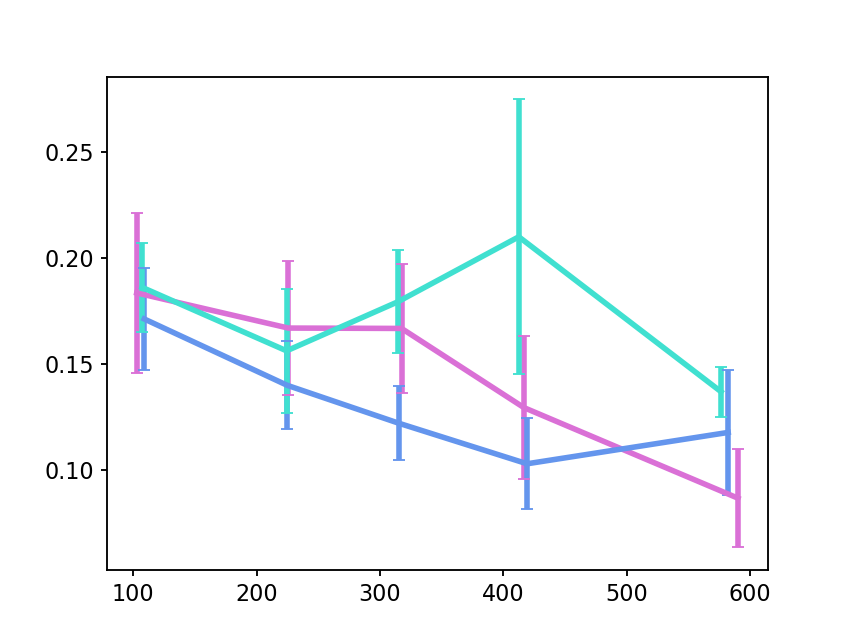

In [361]:

fig, ax = pl.subplots()
for visual_area, df0 in corrs[corrs.arousal=='all'].groupby(['visual_area']):
    
    ncells_t = len(np.union1d(df0['row'].unique(), df0['col'].unique())) 
    bin_dists, bin_ccs, bin_errs = binned_cc_by_dist(df0, x_labeler=x_labeler, y_metric=y_metric, 
                                                     use_std=use_std)
    # Plot
#         ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
#                         label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], 
                label='%s (%i)' % (visual_area, ncells_t), lw=3, capsize=3)


In [353]:
corrs.head()

,row,col,signal_cc,animalid,session,arousal,datakey,visual_area,fovnum,noise_cc,distance,binned_dist
0,98,131,0.665893,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.066392,24.748337,0.0
1,98,133,0.041683,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.231489,86.615976,0.0
2,98,137,-0.027682,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.154124,85.240218,0.0
3,98,138,0.471345,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.183680,82.993008,0.0
4,98,140,0.326355,JC073,20190322,all,20190322_JC073_fov1,Li,1,0.215156,121.883811,0.0


In [354]:
corr_means_by_fov = corrs.groupby(['visual_area', 'datakey', 'arousal', 'binned_dist']).mean().reset_index()


In [356]:
corr_means_by_fov.groupby(['visual_area', 'datakey'])['binned_dist'].mean()

visual_area  datakey            
Li           20190322_JC073_fov1    2.0
             20190422_JC076_fov1    2.0
             20190612_JC099_fov1    2.0
             20190614_JC091_fov1    2.0
             20191111_JC120_fov1    2.0
Lm           20190322_JC073_fov1    2.0
             20190430_JC078_fov1    2.0
             20190504_JC078_fov1    2.0
             20190513_JC078_fov1    2.0
             20190517_JC083_fov1    2.0
             20190525_JC084_fov1    2.0
             20190627_JC091_fov1    2.0
V1           20190508_JC083_fov1    1.5
             20190511_JC083_fov1    2.0
             20190522_JC084_fov1    2.0
             20190613_JC097_fov1    2.0
             20190616_JC097_fov1    2.0
             20191006_JC110_fov1    2.0
Name: binned_dist, dtype: float64

In [357]:
[b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in corr_means_by_fov.groupby([x_metric])]

[107.15658906471748,
 225.06238388015524,
 315.586340833492,
 416.3993093455106,
 583.1491881951486]

<IPython.core.display.Javascript object>


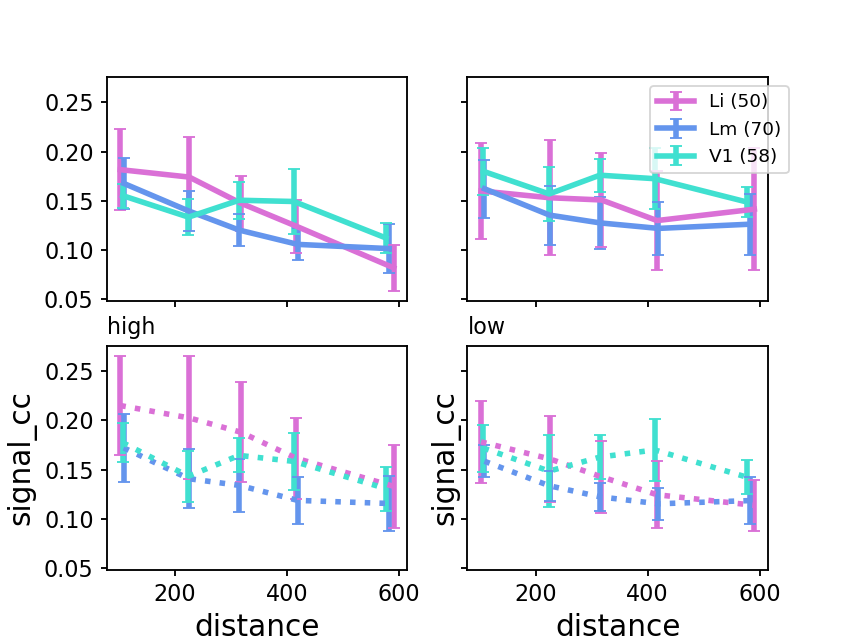

In [360]:
use_std = False

fig, axn = pl.subplots(2, 2, sharex=True, sharey=True)

x_metric = 'binned_dist'
y_metric = 'signal_cc'
fig_title = 'Signal corr. by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for ai, arousal_cond in enumerate(['high', 'low']):
    for visual_area, rdf in corr_means_by_fov.groupby(['visual_area']):
        
        ax=axn[0, ai]
        
        df0 = rdf[rdf.arousal==arousal_cond].copy()
        ncells_t = len(np.union1d(df0['row'].unique(), df0['col'].unique())) 
        bin_dists, bin_ccs, bin_errs = binned_cc_by_dist(df0, x_labeler=x_labeler, y_metric=y_metric, 
                                                         use_std=use_std)
        # plot
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], 
                    label='%s (%i)' % (visual_area, ncells_t), lw=3, capsize=3)
        
        # Shuffled
        ax=axn[1, ai]
        df1 = rdf[rdf.arousal=='%s_shuffled' % arousal_cond].copy()
        bin_dists_shuff, bin_ccs_shuff, bin_errs_shuff = binned_cc_by_dist(df1, x_labeler=x_labeler, 
                                                            y_metric=y_metric, use_std=use_std)
        # plot
        ax.errorbar(bin_dists_shuff, bin_ccs_shuff, yerr=bin_errs_shuff, 
                    color=area_colors[visual_area], lw=3, capsize=3, linestyle=':')
             
                                                         
        ax.set_xlabel(x_labeler)
        ax.set_ylabel(y_metric)
    #ax.set_title(fig_title, fontsize=12, loc='left')
    ax.set_title(arousal_cond, loc='left', fontsize=12)
    
axn[0, 1].legend(bbox_to_anchor=(1.1, 1), loc='upper right')

<IPython.core.display.Javascript object>


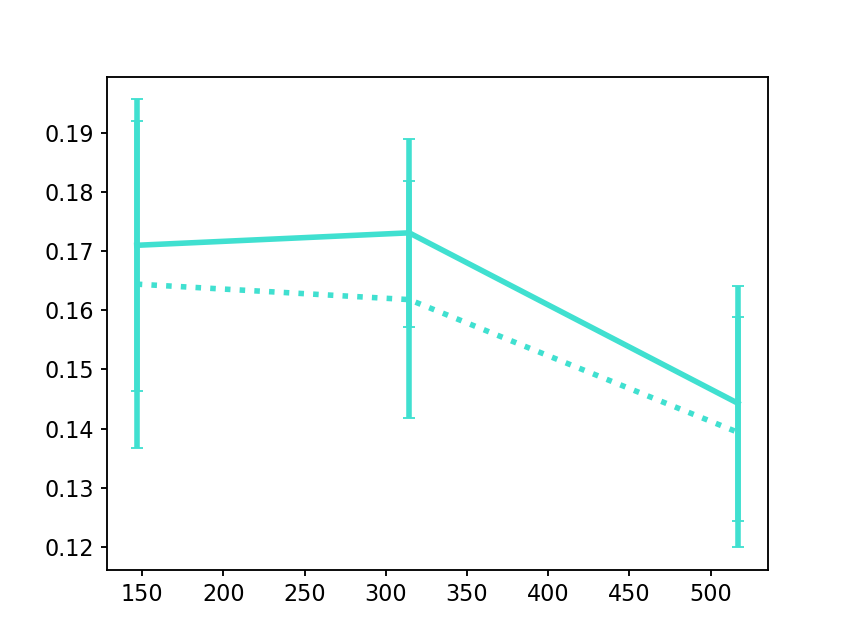

<Container object of 3 artists>

In [325]:
fig, ax = pl.subplots()
ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], 
                label='%s (%i)' % (visual_area, ncells_t), lw=3, capsize=3)
ax.errorbar(bin_dists_shuff, bin_ccs_shuff, yerr=bin_errs_shuff, 
                    color=area_colors[visual_area], lw=3, capsize=3, linestyle=':')
             
                      

In [326]:
meancorrs = corrs.groupby(['visual_area', 'datakey', 'arousal', 'binned_dist']).mean().reset_index()
meancorrs.head()

,visual_area,datakey,arousal,binned_dist,row,col,signal_cc,fovnum,noise_cc,distance
0,Li,20190322_JC073_fov1,all,0.0,211.096210,243.734694,0.277260,1.0,0.256106,124.523760
1,Li,20190322_JC073_fov1,all,1.0,159.804348,251.934783,0.254815,1.0,0.207902,317.208974
2,Li,20190322_JC073_fov1,all,2.0,180.904762,282.583333,0.195450,1.0,0.174043,499.864512
3,Li,20190322_JC073_fov1,high,0.0,211.096210,243.734694,0.301156,1.0,0.256993,124.523760
4,Li,20190322_JC073_fov1,high,1.0,159.804348,251.934783,0.263919,1.0,0.215628,317.208974


In [330]:
meancorrs[meancorrs.arousal.isin(['all', 'high', 'low'])].groupby(['visual_area', 'datakey', 'arousal']).mean()\
.groupby(['visual_area', 'arousal']).mean()

binned_dist         row         col  signal_cc  fovnum  \
visual_area arousal                                                           
Li          all         1.000000  137.640950  217.762263   0.147658     1.0   
            high        1.000000  137.640950  217.762263   0.141190     1.0   
            low         1.000000  137.640950  217.762263   0.147087     1.0   
Lm          all         1.000000  102.607762  187.446848   0.130852     1.0   
            high        1.000000  102.607762  187.446848   0.127445     1.0   
            low         1.000000  102.607762  187.446848   0.135029     1.0   
V1          all         0.916667  110.298609  193.418405   0.167597     1.0   
            high        0.916667  110.298609  193.418405   0.138593     1.0   
            low         0.916667  110.298609  193.418405   0.162750     1.0   

                     noise_cc    distance  
visual_area arousal                        
Li          all      0.123236  330.955400  
            high     0.111869  330.955400  
            low      0.124187  330.955400  
Lm          all      0.116317  327.550131  
            high     0.118973  327.550131  
            low      0.107283  327.550131  
V1          all      0.123077  309.274951  
            high     0.122497  309.274951  
            low      0.117443  309.274951

In [1]:
compare_var='arousal'
c1='high'; c2='low';
currd = meancorrs.copy()
metric = 'signal_cc'


fig, axn = pl.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True) #, dpi=dpi)

ax=axn[0]
ax = aggr.plot_pairwise_by_axis(currd, curr_metric=metric, 
                                c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=False, bbox_to_anchor=(.5, 1),
                                c1_label='H', c2_label='L')
ax.set_xlabel('')
ax.set_title("True labels", loc='left')
statdf0 = aggr.paired_ttests(currd[currd.arousal.isin([c1, c2])], curr_metric=metric, 
                             c1=c1, c2=c2, compare_var=compare_var)


ax=axn[1]
c1='high_shuffled'; c2='low_shuffled';
ax = aggr.plot_pairwise_by_axis(currd, curr_metric=metric, c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1.1, 1.3),
                               c1_label='H', c2_label='L')
ax.set_xlabel('')
ax.set_title("Shuffled labels", loc='left')
statdf1 = aggr.paired_ttests(currd[currd.arousal.isin([c1, c2])], curr_metric=metric, 
                             c1=c1, c2=c2, compare_var=compare_var)

statdf = pd.concat([statdf0, statdf1], axis=1)

fig.text(0.02, 0.93, "Correlations", fontsize=12)

NameError: name 'meancorrs' is not defined